In [1]:
import sys
import os
import joblib
import time

import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import roc_auc_score
import optuna

sys.path.insert(0, os.path.abspath('../..'))
sys.path.insert(0, os.path.abspath('..'))
from utils.metrics import apply_all_metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel


In [57]:
results_dir = "../results_eval_tune"
study_names = [os.path.join(results_dir, study_name) for study_name in os.listdir(results_dir)] #and 'clinical' in study_name]
study_names = [name for name in study_names]
study_names.sort(key=lambda x: x.split('_')[1:])


study_names = ['../results_eval_tune/' + name for name in study_names]

#study_names = [s for s in study_names if "Jun-11" not in s]
study_names = [s for s in study_names if "1k" not in s and "Jun-12" not in s]

for name in study_names:
    print(name.split("/")[-1])

study_names



Jun-11-15:54:10_xgb_0k_10_5
Jun-14-10:57:07_log_0k_10_5
Jun-15-06:18:06_rf_0k_10_5
Jun-15-14:52:34_mlp_0k_10_5


['../results_eval_tune/../results_eval_tune/Jun-11-15:54:10_xgb_0k_10_5',
 '../results_eval_tune/../results_eval_tune/Jun-14-10:57:07_log_0k_10_5',
 '../results_eval_tune/../results_eval_tune/Jun-15-06:18:06_rf_0k_10_5',
 '../results_eval_tune/../results_eval_tune/Jun-15-14:52:34_mlp_0k_10_5']

In [58]:
metrics_of_interest = ["accuracy", "roc_auc", "pr_auc", "1.0_precision", "sensitivity", "specificity"]


In [59]:
def load_studies(study_list):
    all_y_pred_logits = []
    all_y_pred_binary = []
    all_y_pred_binary_roc = []
    all_y_true = []
    study_names = []
    model_names = []
    for study_name in study_list:
        names = ["hyperparams", "eval_score", "score_dict", "y_pred_logits", "y_pred_binary", "y_true"]
        y_pred_logits = []
        y_pred_binary = []
        y_pred_binary_roc = []
        y_true = []

        for file in os.listdir(study_name):
            if file.endswith(".pkl") and file != "cfg.pkl":
                study = joblib.load(os.path.join(study_name, file))
                y_pred_logits_, y_true_ = study[3], study[5]
                y_pred_logits += [y_pred_logits_]
                y_true += [y_true_]
                y_pred_binary += [binarize_predictions(y_pred_logits_, y_true_, curve_type="recall")]
                y_pred_binary_roc += [binarize_predictions(y_pred_logits_, y_true_, curve_type="roc")]

        print(f"Study {study_name} has {len(y_pred_logits)} studies.")
        if len(y_pred_logits) > 0:
            all_y_pred_logits += [y_pred_logits]
            all_y_pred_binary += [y_pred_binary]
            all_y_pred_binary_roc += [y_pred_binary_roc]
            all_y_true += [y_true]
            study_names += [study_name]
            model_names += ["_".join(os.path.basename(study_name).split("_")[0:])]# + "_" + '_'.join(os.path.basename(study_name).split("_")[6:])]

    return all_y_pred_logits, all_y_pred_binary, all_y_pred_binary_roc, all_y_true, study_names, model_names

# Evaluate

In [60]:
from sklearn.metrics import recall_score

def _maximize_curve(y_pred_logits, y_true, curve_type):
    if curve_type == "pr":
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred_logits)
        sums = np.sum([precision, recall], axis=0)
    elif curve_type == "roc":
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_logits)
        sums = np.sum([fpr, tpr], axis=0)
    elif curve_type == "recall":
        thresholds = list(np.linspace(0, 0.2, 500)) + list(np.linspace(0.1, 1.0, 100))
        goal = 0.95
        sums = [1 - abs(goal - recall_score(y_true, y_pred_logits > t)) for t in thresholds]
        #sums = []
        #for thresh in thresholds:
        #    binarized = y_pred_logits > thresh
        #    recall = sklearn.metrics.recall_score(y_true, binarized)
        #    score = 1 - abs(goal - recall)
        #    sums.append(score)
            
    max_thresh = thresholds[np.argmax(sums)]
    return max_thresh

def binarize_predictions(y_pred_logits, y_true, curve_type="recall"):
    thresh = _maximize_curve(y_pred_logits, y_true, curve_type)
    y_pred_binary = y_pred_logits > thresh
    return y_pred_binary

In [61]:
all_y_pred_logits, all_y_pred_binary, all_y_pred_binary_roc, all_y_true, study_names, model_names = load_studies(study_names)

Study ../results_eval_tune/../results_eval_tune/Jun-11-15:54:10_xgb_0k_10_5 has 10 studies.
Study ../results_eval_tune/../results_eval_tune/Jun-14-10:57:07_log_0k_10_5 has 10 studies.
Study ../results_eval_tune/../results_eval_tune/Jun-15-06:18:06_rf_0k_10_5 has 10 studies.
Study ../results_eval_tune/../results_eval_tune/Jun-15-14:52:34_mlp_0k_10_5 has 5 studies.


In [62]:
def get_metric_dict(y_true, y_pred_binary, y_pred_logits):
    # report_dict = _flatten_dict(classification_report(y_true, y_pred, output_dict=True))
    # report_dict['roc_auc'] = roc_auc_score(y_true, y_pred_logits)
    # report_dict['pr_auc'] = average_precision_score(y_true, y_pred_logits)
    # report_dict['sensitivity'], report_dict['specificity'] = _sensitivity_specificity(y_true, y_pred)
    metric_dict = apply_all_metrics(y_true, y_pred_binary, y_pred_logits, shape_is_correct=True)
    #metric_dict["recall"] = recall_score(y_true, y_pred_binary)
    old_prec = metric_dict["1.0_precision"]
    if len(np.unique(y_pred_binary)) == 1:
        if int(np.unique(y_pred_binary)[0]) == 0:
            metric_dict["1.0_precision"] = 1
            print("Only one prediction type!")
            print(np.unique(y_pred_binary))
            print("Overwrite!")
            
    if len(np.unique(y_true)) == 1:
        print("Only one label type!")
        print(np.unique(y_true))
    #else:
    #    prec = precision_score(y_true, y_pred_binary)
    #metric_dict["1.0_precision"] = precision_score(y_true, y_pred_binary) if not (len(np.unique(y_pred_binary)) == 1 and np.unique(y_pred_binary)[0] == 0) else 1
    
    if old_prec != metric_dict["1.0_precision"]:
        print(old_prec, metric_dict["1.0_precision"])
        
        
        
    prec = average_precision_score(y_true, y_pred_binary)
    #print(prec)
    #print(metric_dict["1.0_precision"])
    #print()
    return metric_dict
    

In [63]:
def compute_metrics(all_y_pred_logits, all_y_pred_binary, all_y_true, study_names, model_names):
    metric_names = ["0.0_precision", "0.0_recall", "0.0_f1-score", "0.0_support", "1.0_precision", "1.0_recall", "1.0_f1-score", "1.0_support", "accuracy", "macro  avg_precision", "macro avg_recall", "macro avg_f1-score", "macro avg_support", "weighted avg_precision", "weighted avg_recall", "weighted avg_f1-score", "weighted avg_support", "roc_auc", "pr_auc", "sensitivity", "specificity"]
    report_agg = pd.DataFrame(columns=metric_names+['study_name', 'model_name'])
    r = 0
    for i in range(len(all_y_pred_logits)):
        for j in range(len(all_y_pred_logits[i])):
            results_dict = get_metric_dict(all_y_true[i][j], all_y_pred_binary[i][j], all_y_pred_logits[i][j])
            report_agg.loc[r, :] = list(results_dict.values()) + [study_names[i]] + [model_names[i]]
            r += 1
    return report_agg

In [64]:
#print("binarized with pr:", all_y_pred_binary, "\nbinarized with roc:", all_y_pred_binary_roc)
metric_dfs = compute_metrics(all_y_pred_logits, all_y_pred_binary, all_y_true, study_names, model_names)

In [65]:
metric_dfs_roc = compute_metrics(all_y_pred_logits, all_y_pred_binary_roc, all_y_true, study_names, model_names)

In [66]:
def _get_confidence_interval(metrics_df, n, model_name, sign_level='95'):
    z_values = {'90': 1.64, '95': 1.96, '98': 2.33, '99': 2.58}
    interval = lambda metric, sd :  z_values[sign_level] * (sd / sqrt(n))
    intervals = [interval(metrics_df.loc[f"Mean_{model_name}", col], metrics_df.loc[f"SD_{model_name}", col]) for col in metrics_df.columns]
    #print("\nConfidence offsets", intervals)
    lower = metrics_df.loc[f"Mean_{model_name}", :] - intervals
    upper = metrics_df.loc[f"Mean_{model_name}", :] + intervals
    metrics_df.loc[f"CI_{model_name}", :] = [f"[{l:.1f}, {u:.1f}]" for l, u in zip(lower, upper)]
    #metrics_df.loc[f"CI_upper_{model_name}", :] = metrics_df.loc[f"Mean_{model_name}", :] + intervals
    return metrics_df

In [67]:
def compute_mean_sd_ci(df):
    mean_sd = pd.DataFrame(columns=metrics_of_interest)
    for model_name in df.model_name.unique():
        mean_sd.loc[f"Mean_{model_name}", :] = df.loc[df["model_name"] == model_name, metrics_of_interest].mean().round(3) * 100
        mean_sd.loc[f"SD_{model_name}", :] = df.loc[df["model_name"] == model_name, metrics_of_interest].std().round(3) * 100
        mean_sd = _get_confidence_interval(mean_sd, len(df[df["model_name"] == model_name]), model_name)
        mean_sd = mean_sd.drop(f"SD_{model_name}")
        #print(len(df[df["model_name"] == model_name]))
    
    dest_path = "../nested_cv_eval_results"
    os.makedirs(dest_path, exist_ok=True)
    mean_sd.to_csv(os.path.join(dest_path, f"all_studies_cum_metrics.csv"))
    return mean_sd

In [68]:
avgs_dfs = compute_mean_sd_ci(metric_dfs)
avgs_dfs

,accuracy,roc_auc,pr_auc,1.0_precision,sensitivity,specificity
Mean_Jun-11-15:54:10_xgb_0k_10_5,27.4,72.6,21.1,8.0,95.1,22.6
CI_Jun-11-15:54:10_xgb_0k_10_5,"[24.5, 30.3]","[71.7, 73.5]","[19.2, 23.0]","[7.7, 8.3]","[95.0, 95.2]","[19.5, 25.7]"
Mean_Jun-14-10:57:07_log_0k_10_5,24.2,72.5,20.8,7.7,95.1,19.2
CI_Jun-14-10:57:07_log_0k_10_5,"[20.9, 27.5]","[71.3, 73.7]","[18.6, 23.0]","[7.4, 8.0]","[95.0, 95.2]","[15.7, 22.7]"
Mean_Jun-15-06:18:06_rf_0k_10_5,23.6,71.9,21.0,7.6,95.0,18.6
CI_Jun-15-06:18:06_rf_0k_10_5,"[21.9, 25.3]","[70.5, 73.3]","[19.4, 22.6]","[7.4, 7.8]","[94.8, 95.2]","[16.8, 20.4]"
Mean_Jun-15-14:52:34_mlp_0k_10_5,20.5,69.0,18.6,7.4,95.1,15.2
CI_Jun-15-14:52:34_mlp_0k_10_5,"[15.4, 25.6]","[65.7, 72.3]","[15.0, 22.2]","[7.0, 7.8]","[94.9, 95.3]","[9.7, 20.7]"


In [69]:
paper_df = avgs_dfs.copy()
paper_df.columns = ["Accuracy", "ROC AUC", "AP", "Precision", "Recall/Sensitivity", "Specificity"]

new_df = pd.DataFrame()
for i in range(0, len(paper_df), 2):
    merged_row = paper_df.iloc[i].astype(str).str[0:4] + " " + paper_df.iloc[i + 1].astype(str)
    index = paper_df.index[i].split("_")
    first = index[1]
    if first == "xgb":
        first = "GBT"
    elif first == "log":
        first = "LogReg"
    elif first == "mlp":
        first = "MLP"
    end = index[6:]
    end = [dt[0].upper() + dt[1:] for dt in end]
    end = " + ".join(end)
    end = end.replace("Sparse + Img", "Sparse Imaging")
    end = end.replace(" Imaging + Pca", "Imaging")
    #end = end[0].upper() + end[1:]
    index = first + " " + end
    
    merged_row["Model & Data"] = index
    new_df = new_df.append(merged_row, ignore_index=True)

new_df = new_df[["Model & Data", "ROC AUC", "AP", "Precision", "Recall/Sensitivity", "Specificity", "Accuracy"]]
new_df = new_df.set_index("Model & Data")

In [70]:
def index_order(index):
    if "LogReg" in index:
        val = 30
    elif "GBT" in index:
        val = 20
    else:
        val = 10
    return val

def apply_index_order(index_list):
    index_list = [index_order(index_list[i]) for i in range(len(index_list))]
    return index_list

new_df.sort_index(key=apply_index_order, ascending=False)
no_ci = avgs_dfs.copy()
no_ci = no_ci.iloc[[i for i, name in enumerate(no_ci.index) if not name.startswith("CI_")]]
no_ci.index = [name.replace("Mean_", "").replace("freeze_", "").replace("10_5_", "").replace("5k_", ""). replace("1k_", "") for name in no_ci.index]

In [71]:
no_ci

,accuracy,roc_auc,pr_auc,1.0_precision,sensitivity,specificity
Jun-11-15:54:10_xgb_0k_10_5,27.4,72.6,21.1,8.0,95.1,22.6
Jun-14-10:57:07_log_0k_10_5,24.2,72.5,20.8,7.7,95.1,19.2
Jun-15-06:18:06_rf_0k_10_5,23.6,71.9,21.0,7.6,95.0,18.6
Jun-15-14:52:34_mlp_0k_10_5,20.5,69.0,18.6,7.4,95.1,15.2


In [ ]:
# Table to doc

import docx
import pandas as pd

# open an existing document
name = '../docs/report.docx'
doc = docx.Document(name)
df = new_df
cols = list(df.columns)
df["Model & Data"] = list(df.index)
df = df[["Model & Data"] + cols]
# add a table to the end and create a reference variable
# extra row is so we can add the header row
t = doc.add_table(df.shape[0]+1, df.shape[1])

# add the header rows.
for j in range(df.shape[-1]):
    t.cell(0,j).text = df.columns[j]

# add the rest of the data frame
for i in range(df.shape[0]):
    for j in range(df.shape[-1]):
        t.cell(i+1,j).text = str(df.values[i,j])

# save the doc
doc.save('../docs/test.docx')no_ci.sort_values("roc_auc")

In [ ]:
#index = avgs_dfs.index#
#avgs_dfs[~avgs_dfs.index.str.contains('opt|svc')]

In [ ]:
#compute_mean_sd_ci(metric_dfs_roc)

# t-Test

In [ ]:
metric_dfs["model_name"]

In [ ]:
metric_dfs.loc[metric_dfs["model_name"] == "mlp_clinical", "pr_auc"].mean()

In [ ]:
xgb_name = "xgb_5k_freeze_10_5_clinical"

In [ ]:
log_name = "log_5k_freeze_10_5_clinical"

In [ ]:
metric_dfs.loc[metric_dfs["model_name"] == xgb_name, "pr_auc"].mean()

In [ ]:
metric_dfs.loc[metric_dfs["model_name"] == log_name, "pr_auc"].mean()

In [ ]:
ttest_rel(metric_dfs.loc[metric_dfs["model_name"] == xgb_name, "pr_auc"], metric_dfs.loc[metric_dfs["model_name"] == log_name, "pr_auc"], axis=0, nan_policy='propagate')

In [ ]:
metric_dfs.loc[metric_dfs["model_name"] == "xgb_clinical", "roc_auc"].mean()

In [ ]:
metric_dfs.loc[metric_dfs["model_name"] == "log_clinical", "roc_auc"].mean()

In [ ]:
0.087/2

In [ ]:
ttest_rel(metric_dfs.loc[metric_dfs["model_name"] == "mlp_clinical", "pr_auc"], metric_dfs.loc[metric_dfs["model_name"] == "log_clinical", "pr_auc"], axis=0, nan_policy='propagate')

# Plotting

In [72]:
def get_plot_names(model_name):
    linestyle = '-' if 'xgb' in model_name else '--'
    
    stylized_name = ""
    if 'xgb' in model_name:
        stylized_name += 'GBT'
    elif 'svc' in model_name:
        stylized_name += 'SVM'
    elif 'log' in model_name:
        stylized_name += 'LogReg'
    elif 'mlp' in model_name.lower():
        stylized_name += 'MLP'
    elif "rf" in model_name.lower():
        stylized_name += 'RF'
    return linestyle, stylized_name

In [73]:
def plot_roc_kfold(y_pred, y, color, model_name, ax):
    """Create a receiver operating characteristic plot for every k-fold split set on the provided ax."""
    linestyle, stylized_name = get_plot_names(model_name)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    # Individual curves
    for idx in range(len(y_pred)):
        fpr, tpr, thresholds = roc_curve(y[idx], y_pred[idx])
        
        df = pd.DataFrame({'x': fpr, 'y': tpr}).sort_values(by='x')
        interp_tpr = np.interp(mean_fpr, df['x'], df['y'])
        #interp_tpr = np.interp(mean_fpr, fpr, tpr)
        
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))
    # Mean curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr) * 100
    std_auc = np.std(aucs) * 100
    ax.plot(mean_fpr, mean_tpr, color=color, linestyle=linestyle, lw=2, alpha=1, label=f'{stylized_name} AUC=%0.1f\u00B1%0.1f' %
                                                                 (mean_auc, std_auc))
    # Grey confidence intervals
    std_tpr = np.std(tprs, axis=0) / sqrt(len(y_pred))
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color, alpha=.2)  # label=r'$\pmodel_type$ 1 std. dev.')

    # Title and legend
    ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], title="Receiver operating characteristic (ROC)")
    ax.set_xlabel('1 - Specificity')
    ax.set_ylabel('Sensitivity')
    ax.legend(loc="lower right")

In [74]:
plot_colors = ["#C52230", "#0073EE", "#A222C7", '#178A07'] * 2#, '#FFA500'] * 2


In [75]:
legend_outside = True

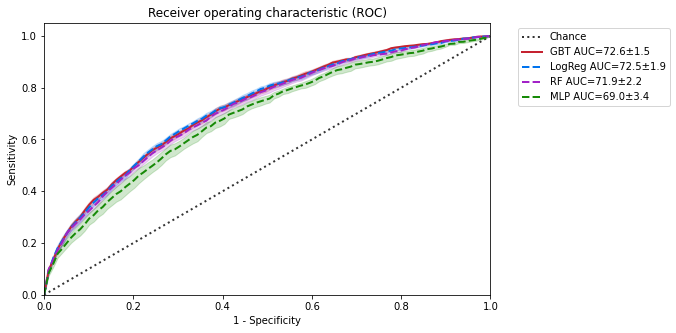

In [76]:
import matplotlib._color_data as mcd


fig, ax = plt.subplots(1, 1, figsize=(8, 5))
# The diagonal line
ax.plot([0, 1], [0, 1], linestyle=':', lw=2, color='black', label='Chance', alpha=.8)


for i in range(len(study_names)):
    plot_roc_kfold(all_y_pred_logits[i], all_y_true[i], plot_colors[i], f"{model_names[i]}", ax)
if legend_outside:
    lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    lgd = plt.legend()
dest_path = os.path.join("../nested_cv_eval_results", f"ROC_plot_{'legend_out' if legend_outside else 'legend_in'}.jpg")
fig.savefig(dest_path, dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close()

In [77]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

def get_prec_rec_thresh(y_true, y_score):
    threshs = np.linspace(0, 1, 1000)
    recs = [recall_score(y_true, y_score > t) for t in threshs]
    precs = []
    for t in threshs:
        if (len(np.unique(y_score > t)) == 1) and np.unique(y_score > t)[0] == 0:
            prec = 1
        else:
            prec = precision_score(y_true, y_score > t)
        precs.append(prec)
    #precs = [precision_score(y_true, y_score > t) if not (len(np.unique(y_score > t)) == 1 and np.unique(y_score > t)[0] == 0) else 1 for t in threshs]
    #print("R", recs)
    #print("P", precs)
    return np.array(precs), np.array(recs), threshs

In [78]:
def plot_pc_kfold(y_pred, y, color, model_name, ax):
    """Create a receiver operating characteristic plot for every k-fold split set on the provided ax."""
    linestyle, stylized_name = get_plot_names(model_name)
    print(stylized_name)
    
    aucs = []
    interps = []
    interp_points = np.linspace(0, 1, 100)
    
    use_manual_thresholds = False
    precs_at = []
    # Individual curves
    for idx in range(len(y_pred)):
        if use_manual_thresholds:
            precision, recall, thresholds = get_prec_rec_thresh(y[idx], y_pred[idx])
        else:
            precision, recall, thresholds = precision_recall_curve(y[idx], y_pred[idx])
            
        close_to_95 = np.argmax(1 - abs(0.95 - recall))
        prec_at = precision[close_to_95]
        precs_at.append(prec_at)
        
        df = pd.DataFrame({'x': recall, 'y': precision}).sort_values(by='x')
        interp_prec = np.interp(interp_points, df['x'], df['y'])
        interps.append(interp_prec)
        

        ap_skl = average_precision_score(y[idx], y_pred[idx])
        ap_real = np.mean(interp_prec)
        #print(ap_skl, ap_real, np.mean(recall))
        aucs.append(ap_skl)
        
        

    # Mean curve    
    mean_prec = np.mean(interps, axis=0)
    std_prec = np.std(interps, axis=0) / sqrt(len(y_pred)) # standard error
    mean_rec = interp_points
    
    
    close_to_95 = np.argmax(1 - abs(0.95 - mean_rec))
    print(f"Precision at {np.round(mean_rec[close_to_95] * 100, 1)}% Recall: ", mean_prec[close_to_95])
    print("Mean prec at : ", np.mean(precs_at))
    
    mean_auc = np.mean(aucs) * 100
    #print("Mean skl auc: ", mean_auc)
    #print("Mean our auc: ", np.mean(mean_prec))
    std_auc = np.std(aucs) * 100
    ax.plot(mean_rec, mean_prec, color=color, linestyle=linestyle, lw=2, alpha=1, label=f'{stylized_name} AP=%0.1f\u00B1%0.1f' %
                                                                 (mean_auc, std_auc))
    # Grey confidence intervals
    tprs_upper = np.minimum(mean_prec + std_prec, 1)
    tprs_lower = np.maximum(mean_prec - std_prec, 0)
    ax.fill_between(mean_rec, tprs_lower, tprs_upper, color=color, alpha=.2)  # label=r'$\pmodel_type$ 1 std. dev.')

    # Title and legend
    ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], title="Precision-Recall Curve")
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend(loc="upper right")

GBT
Precision at 94.9% Recall:  0.08069900218509168
Mean prec at :  0.08021399355312245
LogReg
Precision at 94.9% Recall:  0.07824060677324197
Mean prec at :  0.07768441758068786
RF
Precision at 94.9% Recall:  0.07734195260471485
Mean prec at :  0.07669808404519467
MLP
Precision at 94.9% Recall:  0.07403739409420351
Mean prec at :  0.0738560473857804


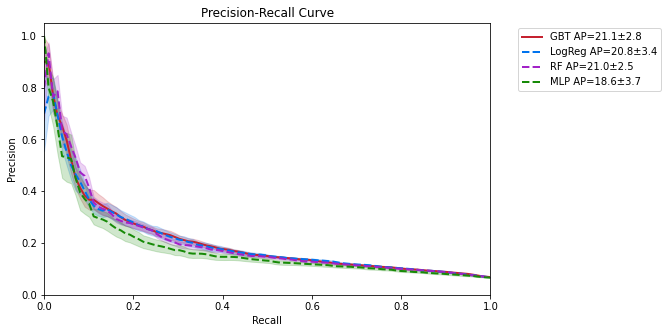

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
# The diagonal line

for i in range(len(study_names)):
    plot_pc_kfold(all_y_pred_logits[i], all_y_true[i], plot_colors[i], f"{model_names[i]}", ax)

if legend_outside:
    lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    lgd = plt.legend()
dest_path = os.path.join("../nested_cv_eval_results", f"PR_plot_{'legend_out' if legend_outside else 'legend_in'}.jpg")
fig.savefig(dest_path, dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close()

GBT
Precision at 94.9% Recall:  0.08069900218509168
Mean prec at :  0.08021399355312245
LogReg
Precision at 94.9% Recall:  0.07824060677324197
Mean prec at :  0.07768441758068786
RF
Precision at 94.9% Recall:  0.07734195260471485
Mean prec at :  0.07669808404519467
MLP
Precision at 94.9% Recall:  0.07403739409420351
Mean prec at :  0.0738560473857804


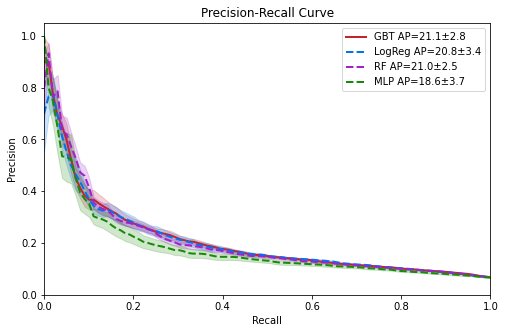

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
# The diagonal line

for i in range(len(study_names)):
    plot_pc_kfold(all_y_pred_logits[i], all_y_true[i], plot_colors[i], f"{model_names[i]}", ax)

dest_path = os.path.join("../nested_cv_eval_results", f"PR_plot.jpg")
fig.savefig(dest_path, dpi=300)
plt.show()
plt.close()